In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from wordcloud import WordCloud
import sys

In [2]:
# donwload the dataset
df_original = pd.read_parquet('ssh_attacks.parquet')
df=df_original.copy()
df

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


In [18]:
#1. When are the attacks performed? Analyze the temporal series.
df['first_timestamp'] = pd.to_datetime(df['first_timestamp'])

# get a new dataframe where there are only attacks
dfwh = df.loc[~df["Set_Fingerprint"].apply(lambda x : "Harmless" in x and len(x) == 1)]
attacks_per_day = dfwh['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_of_attacks_per_day")
attacks_per_day

,Number_of_attacks_per_day
first_timestamp,
2019-06-04,82
2019-06-05,124
2019-06-06,117
2019-06-07,121
2019-06-08,118
...,...
2020-02-25,649
2020-02-26,483
2020-02-27,551


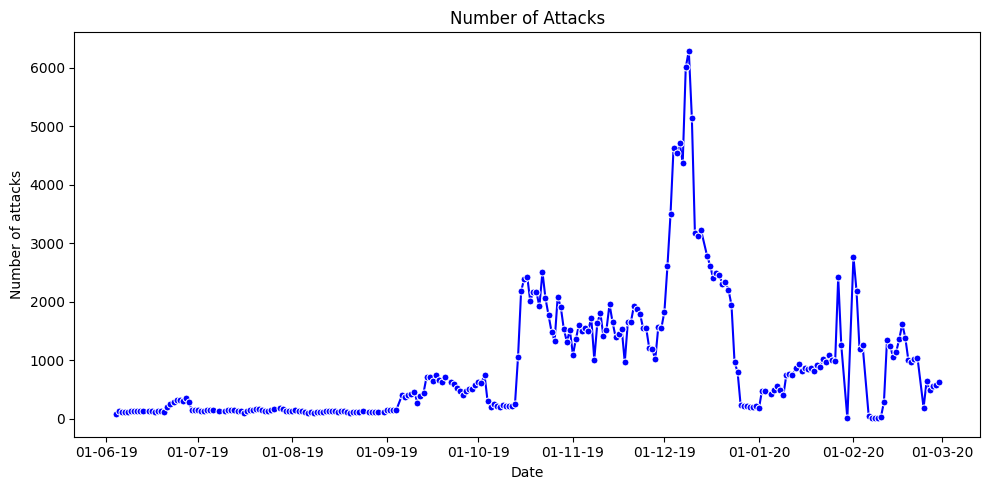

In [19]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data = attacks_per_day,
    x = "first_timestamp",
    y = "Number_of_attacks_per_day",
    marker='o',
    linestyle='-', 
    color= 'blue',
    markersize=5
)
plt.title('Number of Attacks')
plt.xlabel("Date")
plt.ylabel("Number of attacks")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

# # Show the plot
plt.tight_layout()
plt.show()

In [20]:
attacks_per_year = dfwh.groupby(df['first_timestamp'].dt.year).size().to_frame("Number_attacks").reset_index()
attacks_per_year.rename(columns={"first_timestamp": "year"}, inplace=True)
attacks_per_year

,year,Number_attacks
0,2019,186468
1,2020,46342


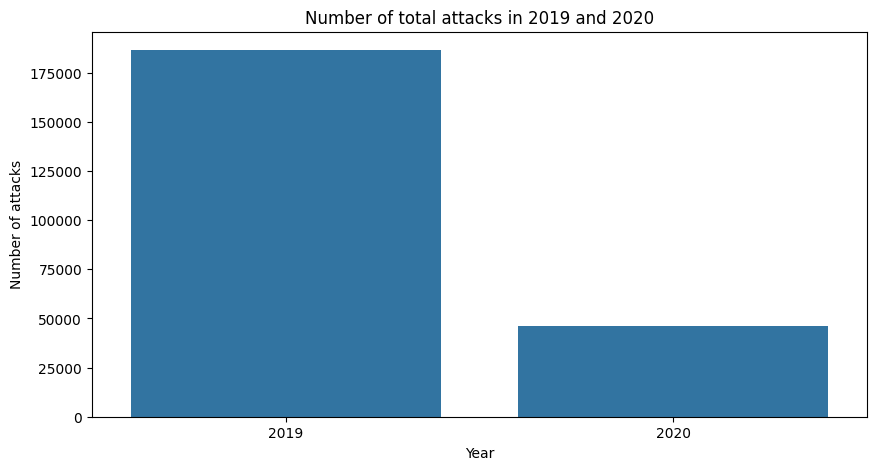

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(
    data = attacks_per_year,
    x = "year",
    y = "Number_attacks"
)
plt.xlabel("Year")
plt.ylabel("Number of attacks")
plt.title("Number of total attacks in 2019 and 2020")
plt.show()

In [22]:
dfwh_2019 = dfwh.loc[dfwh["first_timestamp"].dt.year == 2019]
dfwh_2019_month = dfwh_2019.groupby(dfwh_2019["first_timestamp"].dt.month).size().to_frame("Number_attacks_2019_month").reset_index()
dfwh_2020 = dfwh.loc[dfwh["first_timestamp"].dt.year == 2020]
dfwh_2020_month = dfwh_2020.groupby(dfwh_2020["first_timestamp"].dt.month).size().to_frame("Number_attacks_2020_month").reset_index()

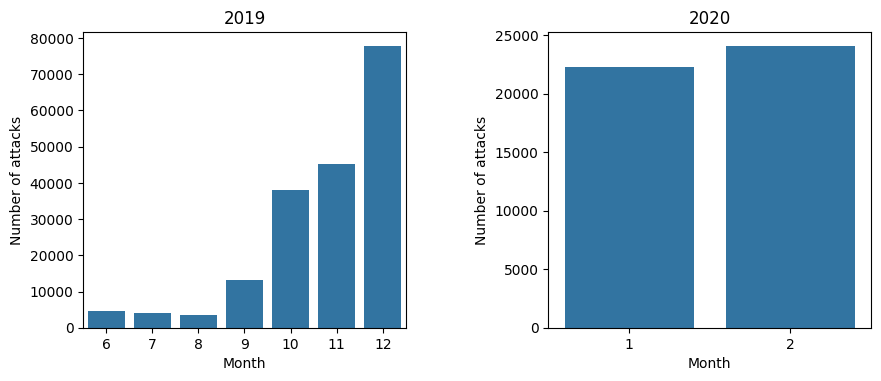

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(
    data = dfwh_2019_month,
    x = "first_timestamp",
    y = "Number_attacks_2019_month"
)
plt.xlabel("Month")
plt.ylabel("Number of attacks")
plt.title("2019")

plt.subplot(1,2,2)
sns.barplot(
    data = dfwh_2020_month,
    x = "first_timestamp",
    y = "Number_attacks_2020_month"
)
plt.xlabel("Month")
plt.ylabel("Number of attacks")
plt.title("2020")

plt.tight_layout(pad = 5)
plt.show()

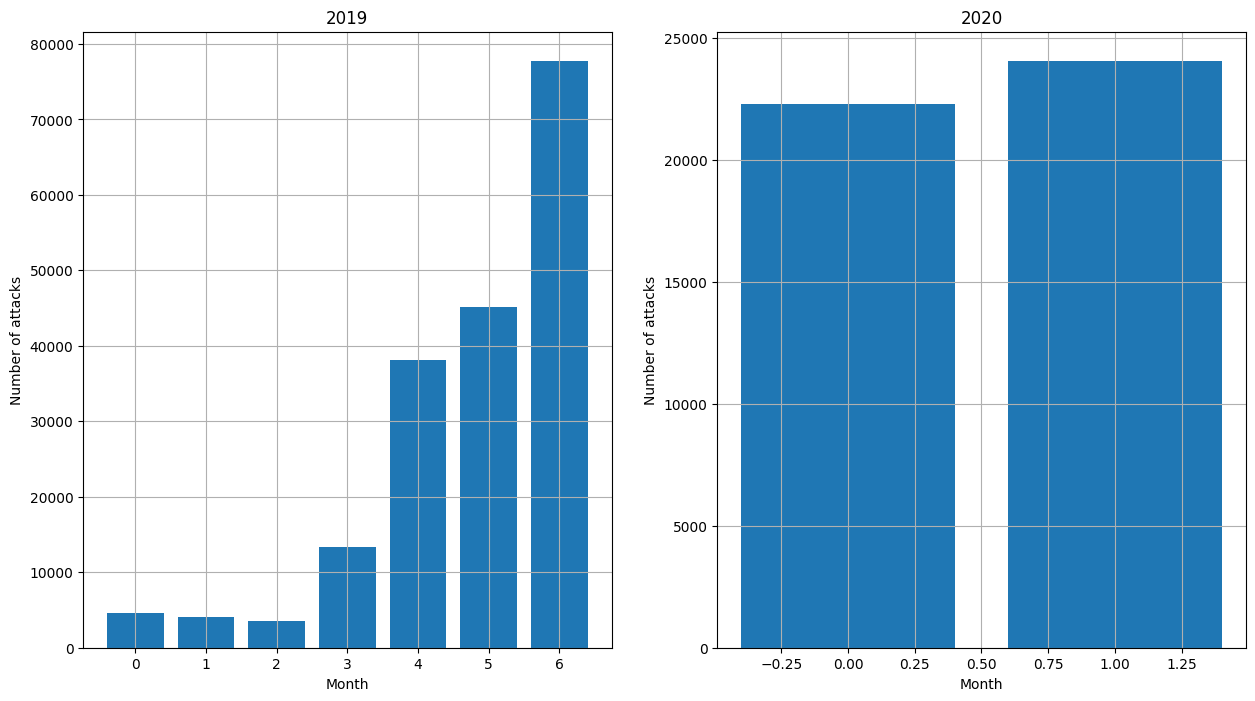

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of attacks')
ax[0].set_title('2019')
ax[0].bar(dfwh_2019_month.index, dfwh_2019_month["Number_attacks_2019_month"] )
ax[0].grid()


ax[1].set_xlabel('Month')
ax[1].set_ylabel('Number of attacks')
ax[1].set_title('2020')
ax[1].bar(dfwh_2020_month.index,  dfwh_2020_month["Number_attacks_2020_month"] )
ax[1].grid()

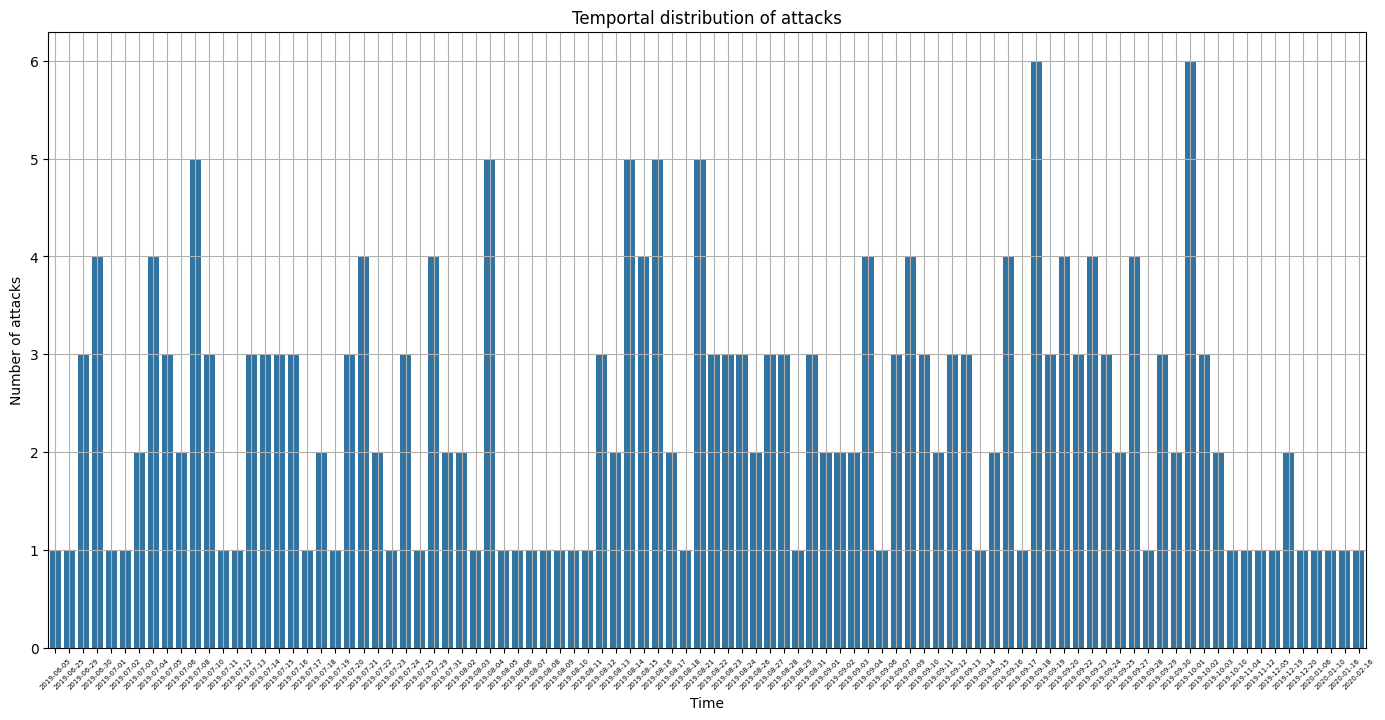

In [26]:
dfoh = df.loc[df["Set_Fingerprint"].apply(lambda x : "Harmless" in x and len(x) == 1)]

harmless_per_day = dfoh['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_harmless_per_day")
plt.figure(figsize=(17, 8))
sns.barplot(
    data = harmless_per_day,
    x="first_timestamp", 
    y="Number_harmless_per_day"
)
plt.xticks(rotation=45, fontsize=5)  # Rotate x-axis labels by 45 degrees
plt.title('Temportal distribution of attacks')
plt.xlabel('Time')
plt.ylabel('Number of attacks')
plt.grid(True)
plt.show()

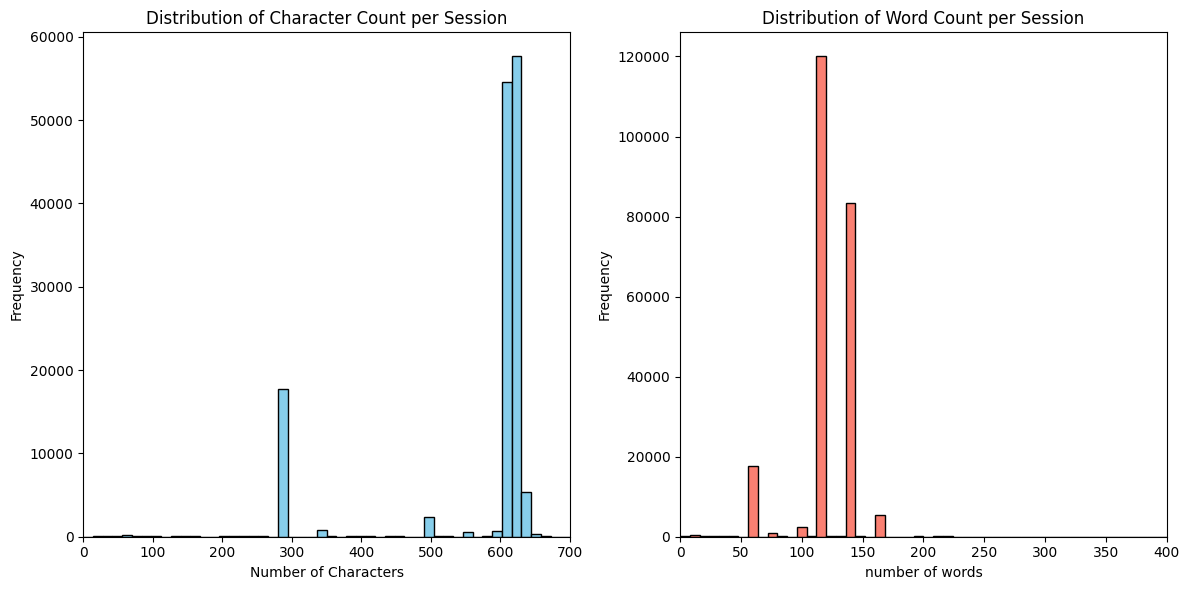

In [27]:
df['num_chars'] = dfwh['full_session'].apply(len)
df['num_words'] = dfwh['full_session'].apply(lambda x: len(x.split()))

# Tracking histograms for character and word counts per session.
plt.figure(figsize=(12, 6))

# Histogram for the number of characters per session.
plt.subplot(1, 2, 1)
plt.hist(df['num_chars'], bins=50,range=(0, 700), color='skyblue', edgecolor='black')
plt.title('Distribution of Character Count per Session')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.xlim(0, 700)

# Histogram for the number of words per session
plt.subplot(1, 2, 2)
plt.hist(df['num_words'], bins=50,range=(0, 400), color='salmon', edgecolor='black')
plt.title('Distribution of Word Count per Session')
plt.xlabel('number of words')
plt.ylabel('Frequency')
plt.xlim(0, 400)

plt.tight_layout()
plt.show()

In [28]:
df_words = df['full_session']
all_text = ' '.join(df['full_session'])

# List with all the possible words
all_words = all_text.split()

# Cleaning the text, leaving only alpha numeric words
cleaning_text = [all_words[i] for i in range(len(all_words)) if all_words[i].isalnum()==True] 

In [29]:
df_list = pd.Series(cleaning_text).value_counts().head(10)


# Identify the most common words and its index
most_common_word = df_list.idxmax()
frequency = df_list.max()

word_freq=df_list.to_dict()

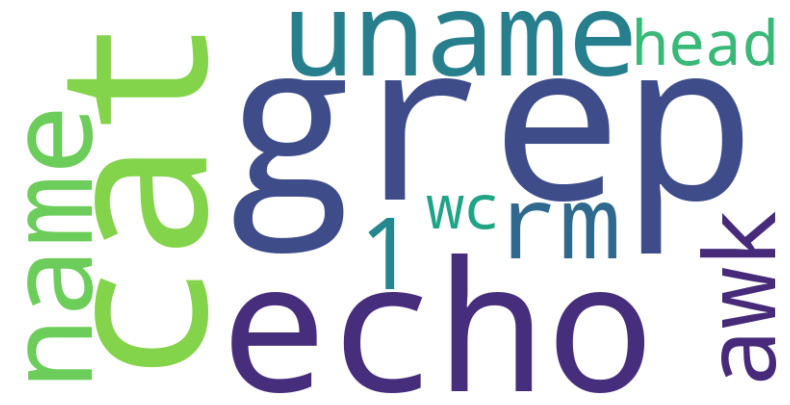

In [30]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

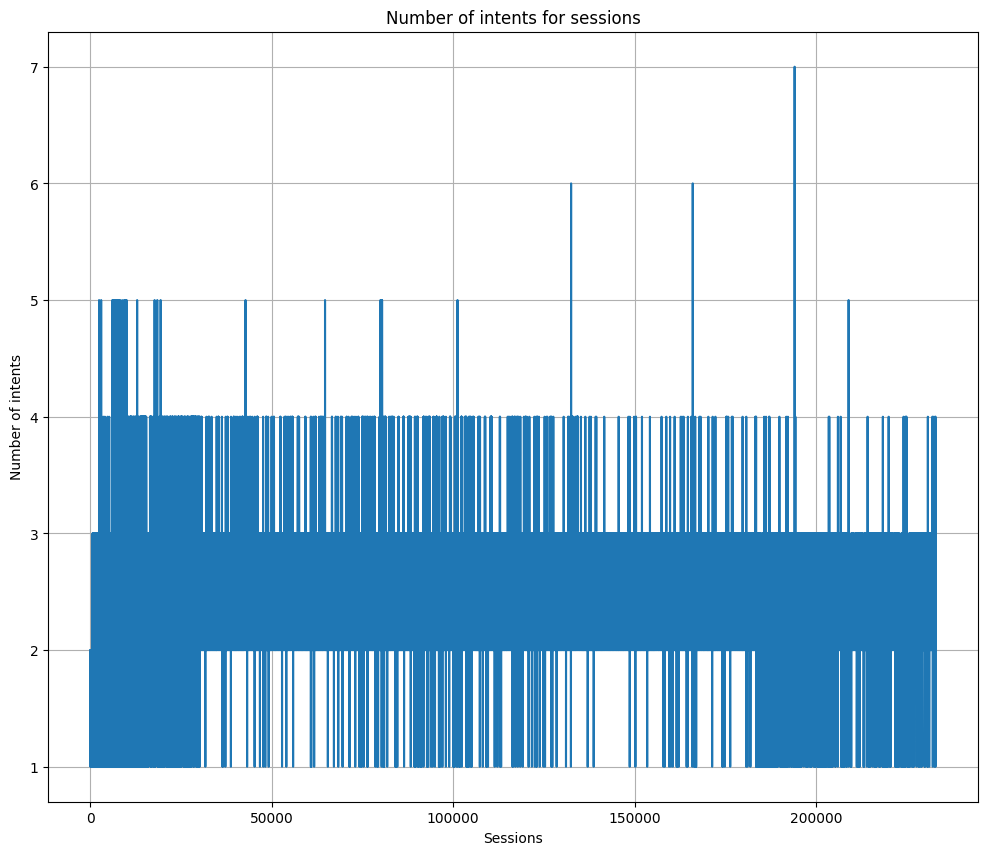

In [15]:
#4.1  How many intents per session do you observe?
intents_df = df[["session_id", "Set_Fingerprint"]]
intents_df_exploted = intents_df.explode('Set_Fingerprint')
intents_df_grouped = intents_df_exploted.groupby("session_id").size()

intents_df_grouped.plot(figsize=(12,10), xlabel="Sessions", ylabel="Number of intents", title="Number of intents for sessions")
plt.grid()

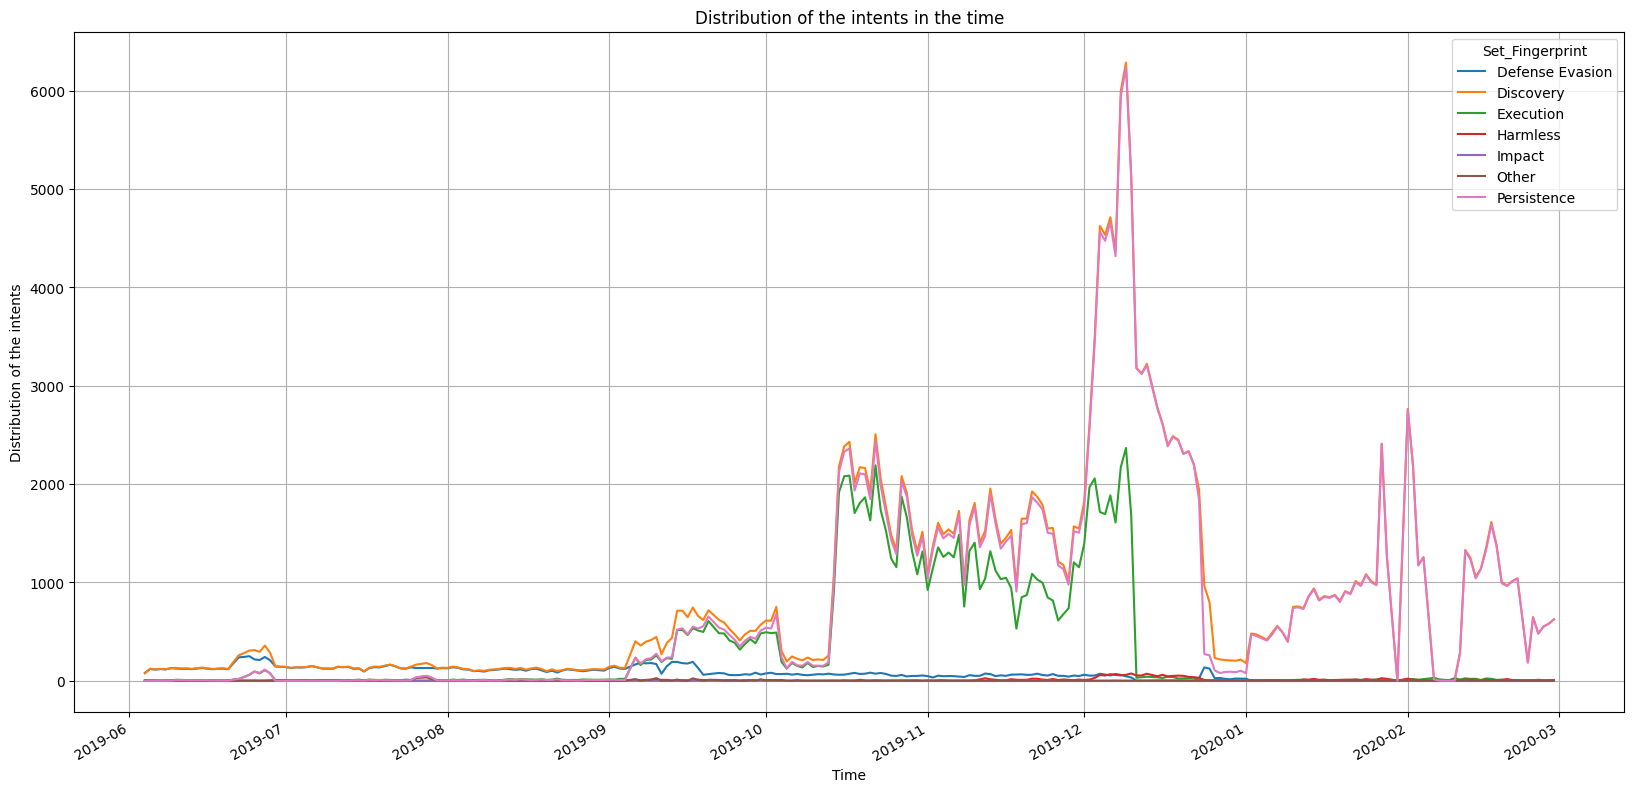

In [16]:
#4.3  How are the intents distributed in time?

# Convert the first_timestamp column to datetime format
df["first_timestamp"] = pd.to_datetime(df["first_timestamp"])


df_grouped = df.explode('Set_Fingerprint').groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().unstack().fillna(0)

df_grouped.plot(figsize=(20,10), xlabel="Time", ylabel="Distribution of the intents", title="Distribution of the intents in the time")
plt.grid()